#Importing data and libraries

In [27]:
from google.colab import files
files.upload()
# choose the file on your computer to upload it then



{}

In [85]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
from scipy.stats import probplot
from scipy import stats
from sklearn.linear_model import LinearRegression
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import shapiro

#Uploading data

In [57]:
df = pd.read_csv("insurance.csv")
df.isnull().sum

<bound method NDFrame._add_numeric_operations.<locals>.sum of         age    sex    bmi  children  smoker  region  charges
0     False  False  False     False   False   False    False
1     False  False  False     False   False   False    False
2     False  False  False     False   False   False    False
3     False  False  False     False   False   False    False
4     False  False  False     False   False   False    False
...     ...    ...    ...       ...     ...     ...      ...
1333  False  False  False     False   False   False    False
1334  False  False  False     False   False   False    False
1335  False  False  False     False   False   False    False
1336  False  False  False     False   False   False    False
1337  False  False  False     False   False   False    False

[1338 rows x 7 columns]>

In [58]:
df.head()


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [59]:
df.shape

(1338, 7)

#Categoral vs Numerical


In [60]:
numerical_features = ['age', 'bmi', 'charges', 'children']
categorical_features = ['sex', 'smoker', 'region']

print(f"Numerical Features:{numerical_features}")
print(f"Categorical_Features:{categorical_features}")

Numerical Features:['age', 'bmi', 'charges', 'children']
Categorical_Features:['sex', 'smoker', 'region']


#Handling data

DUPLICATES

In [61]:
# Check for duplicate rows
duplicate_rows = df.duplicated()

# Count the number of duplicate rows
num_duplicate_rows = duplicate_rows.sum()

# Display the duplicate rows
if num_duplicate_rows > 0:
    print("Duplicate Rows:")
    print(df[duplicate_rows])
else:
    print("No duplicate rows found.")

Duplicate Rows:
     age   sex    bmi  children smoker     region    charges
581   19  male  30.59         0     no  northwest  1639.5631


In [62]:
df = df.drop_duplicates()
df.shape

(1337, 7)

OUTLIERS

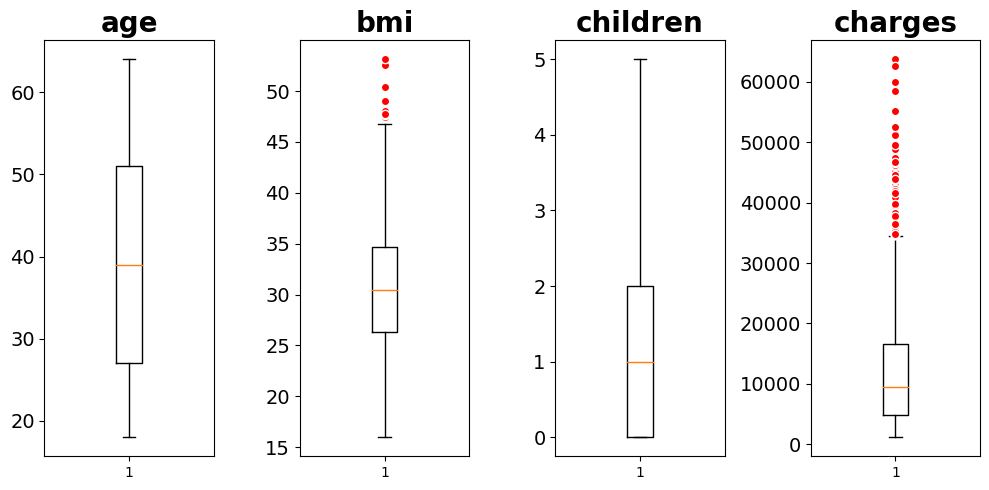

In [63]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(df.select_dtypes(include=["int","float"]).columns), figsize=(10,5))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df.select_dtypes(include=["int","float"]).iloc[:,i], flierprops=red_circle)
    ax.set_title(df.select_dtypes(include=["int","float"]).columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()

As shown in figuare there are outliers in bmi and charges

In [64]:
#setting a threshold and calculating the z_score for both features
thershold = 2
bmi_zscore = np.abs(stats.zscore(df['bmi']))
charges_zscore = np.abs(stats.zscore(df['charges']))

In [65]:
#putting conditions on z_score value to see how many outliers do we have
bmi_outliers = df[ (bmi_zscore > thershold ) | (bmi_zscore <-thershold)]
charges_outliers = df[ (charges_zscore > thershold ) | (charges_zscore <-thershold)]
print(bmi_outliers.shape)
print(charges_outliers.shape)

(57, 7)
(107, 7)


In [66]:
#clearing data from outliers
df = df[(charges_zscore < thershold )& (charges_zscore > -thershold) & (bmi_zscore > -thershold) & (bmi_zscore < thershold)]
df.shape

(1181, 7)

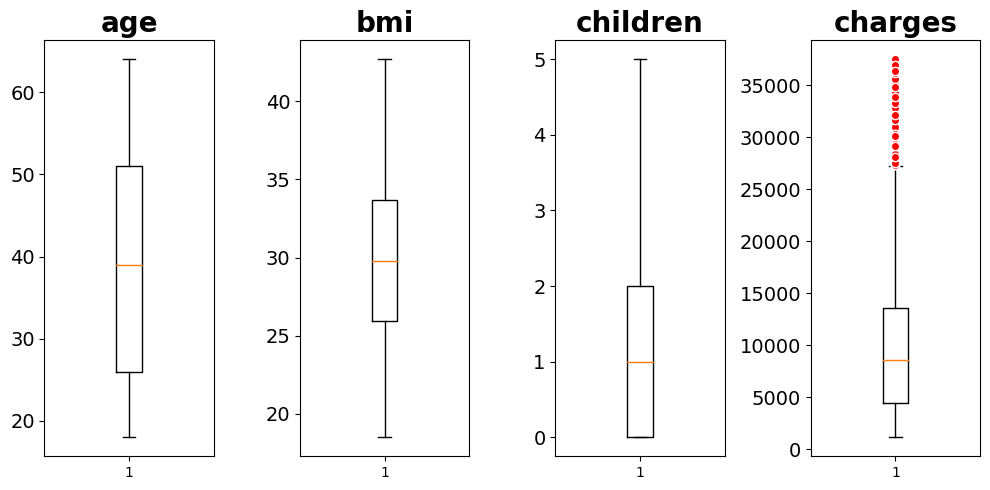

In [67]:
red_circle = dict(markerfacecolor='red', marker='o', markeredgecolor='white')

fig, axs = plt.subplots(1, len(df.select_dtypes(include=["int","float"]).columns), figsize=(10,5))

for i, ax in enumerate(axs.flat):
    ax.boxplot(df.select_dtypes(include=["int","float"]).iloc[:,i], flierprops=red_circle)
    ax.set_title(df.select_dtypes(include=["int","float"]).columns[i], fontsize=20, fontweight='bold')
    ax.tick_params(axis='y', labelsize=14)

plt.tight_layout()

As we see the outliers in bmi ara totaly gone now and in charges it is way more less than before

SEARCHING FOR NULL VALUES

In [68]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


#Descriptive statistics

In [69]:
mode_values = df.mode().iloc[0]
variance_values = df.var()

# Calculate the summary statistics
statistics = df.describe()

# Insert the row with mode values
statistics.loc['mode'] = mode_values
statistics.loc['varience'] = variance_values

# Display the summary statistics
print("Summary Statistics:")
print(statistics)

Summary Statistics:
                  age          bmi     children       charges
count     1181.000000  1181.000000  1181.000000  1.181000e+03
mean        38.768840    30.012358     1.071126  1.072234e+04
std         14.127983     5.334893     1.212934  8.345511e+03
min         18.000000    18.500000     0.000000  1.121874e+03
25%         26.000000    25.935000     0.000000  4.466621e+03
50%         39.000000    29.810000     1.000000  8.596828e+03
75%         51.000000    33.700000     2.000000  1.360737e+04
max         64.000000    42.680000     5.000000  3.748445e+04
mode        18.000000    32.300000     0.000000  1.121874e+03
varience   199.599910    28.461085     1.471208  6.964755e+07


#Standardization of features

\begin{equation}
\mathbf{Zscore} = \frac{\mathbf{x} - \mathbf{\mu}}{\mathbf{\sigma}}
\end{equation}

In [72]:
features_standerd = [ 'bmi' , 'charges', 'age' ]
statistics = df[features_standerd].describe()
df[features_standerd] = (df[features_standerd] - statistics.loc['mean']) / statistics.loc['std']


In [73]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.399268,female,-0.395951,0,yes,southwest,0.738432
1,-1.470050,male,0.704352,1,no,southeast,-1.078039
2,-0.762235,male,0.560019,3,no,southeast,-0.751646
3,-0.408327,male,-1.369729,0,no,northwest,1.349484
4,-0.479109,male,-0.212255,0,no,northwest,-0.821457


#Distribution plotting

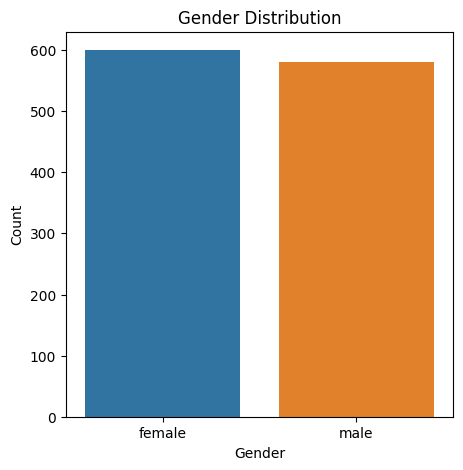

Ditribution Type: Bernoulli Distribution


In [74]:
#gender distribution
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='sex')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.show()
print("Ditribution Type: Bernoulli Distribution")

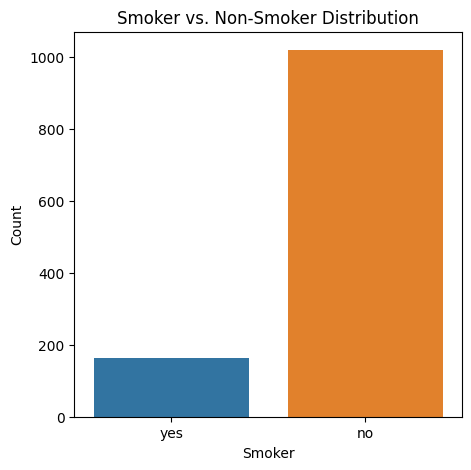

Ditribution Type: Bernoulli Distribution


In [45]:
#smoker distribution
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='smoker')
plt.xlabel('Smoker')
plt.ylabel('Count')
plt.title('Smoker vs. Non-Smoker Distribution')
plt.show()
print("Ditribution Type: Bernoulli Distribution")

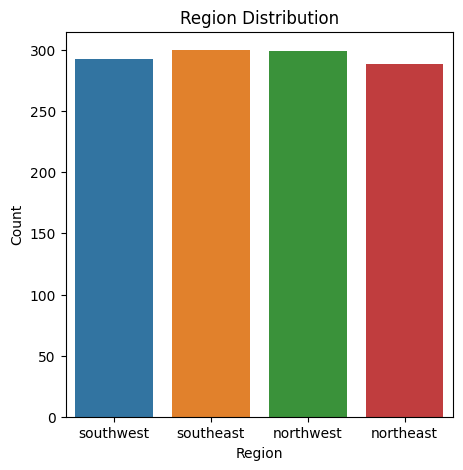

Ditribution Type: Uniform Distribution 


In [46]:
#region distribution
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='region')
plt.xlabel('Region')
plt.ylabel('Count')
plt.title('Region Distribution')
plt.show()
print("Ditribution Type: Uniform Distribution ")

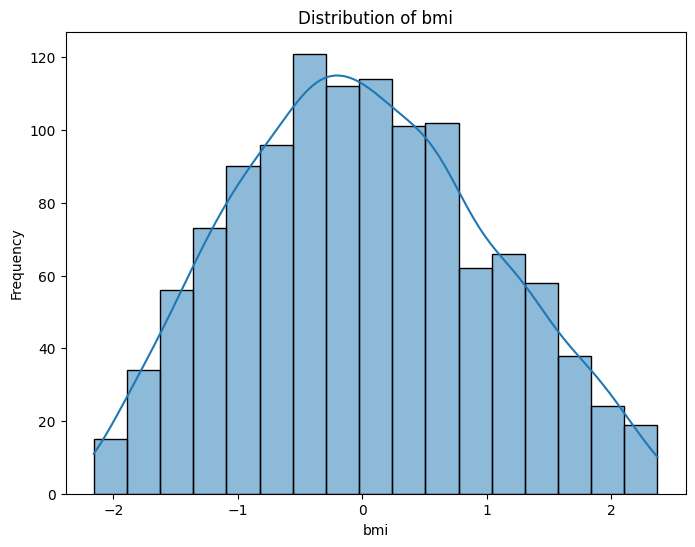

Ditribution Type: Normal Distribution


In [75]:
#bmi distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x=df['bmi'], kde=True)
plt.xlabel('bmi')
plt.ylabel('Frequency')
plt.title(f'Distribution of bmi')
plt.show()
print("Ditribution Type: Normal Distribution")

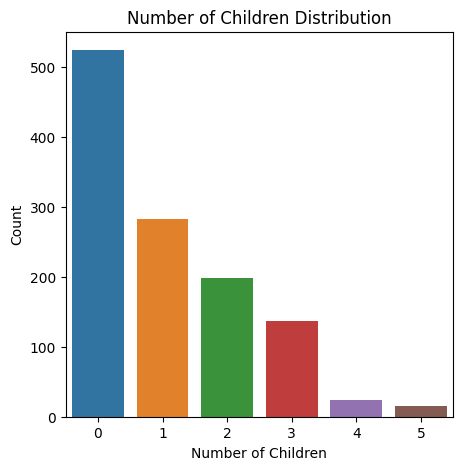

Ditribution Type: Geometric Distribution


In [86]:
#number of children distribution
plt.figure(figsize=(5, 5))
sns.countplot(data=df, x='children')
plt.xlabel('Number of Children')
plt.ylabel('Count')
plt.title('Number of Children Distribution')
plt.show()
print("Ditribution Type: Geometric Distribution")

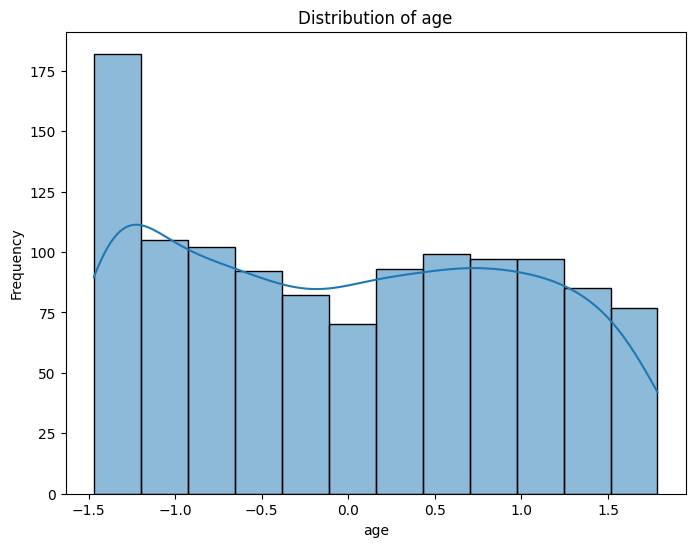

Ditribution Type: Uniform Distribution 


In [87]:
#age distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x=df['age'], kde=True)
plt.xlabel('age')
plt.ylabel('Frequency')
plt.title(f'Distribution of age')
plt.show()
print("Ditribution Type: Uniform Distribution ")


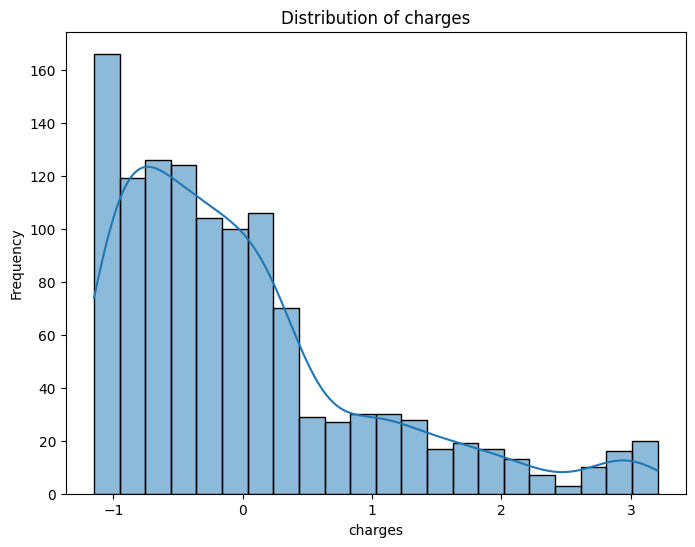

Ditribution Type: Log-Normal Distribution


In [88]:
#charges distribution
plt.figure(figsize=(8, 6))
sns.histplot(data=df, x=df['charges'], kde=True)
plt.xlabel('charges')
plt.ylabel('Frequency')
plt.title(f'Distribution of charges')
plt.show()
print("Ditribution Type: Log-Normal Distribution")

#Normality test

In [76]:
for feature in df[numerical_features]:
    # Perform Shapiro-Wilk test
    statistic, p_value = shapiro(df[feature])
    # Print the results
    print(f"Shapiro-Wilk Test Results: for {feature}")
    print("Test Statistic:", statistic)
    print("p-value:", p_value)

    # Interpret the results
    alpha = 0.05  # significance level
    if p_value < alpha:
        print("Reject the null hypothesis: The data does not follow a normal distribution.")
    else:
        print("Fail to reject the null hypothesis: The data may follow a normal distribution.")

    print('---------------------')

Shapiro-Wilk Test Results: for age
Test Statistic: 0.9412651062011719
p-value: 3.201005197543737e-21
Reject the null hypothesis: The data does not follow a normal distribution.
---------------------
Shapiro-Wilk Test Results: for bmi
Test Statistic: 0.9882089495658875
p-value: 3.72329331810306e-08
Reject the null hypothesis: The data does not follow a normal distribution.
---------------------
Shapiro-Wilk Test Results: for charges
Test Statistic: 0.8684118986129761
p-value: 2.2347923075799168e-30
Reject the null hypothesis: The data does not follow a normal distribution.
---------------------
Shapiro-Wilk Test Results: for children
Test Statistic: 0.8146244287490845
p-value: 8.547356346305382e-35
Reject the null hypothesis: The data does not follow a normal distribution.
---------------------


#Mapping Categorical to Numerical

In [77]:
df["sex"] = df["sex"].map({"female":0, "male":1})
df["smoker"] = df["smoker"].map({"yes":1, "no":0})
df["region"] = df["region"].map({"southwest":0, "southeast":1, "northwest":2, "northeast":3})
df.head()

,age,sex,bmi,children,smoker,region,charges
0,-1.399268,0,-0.395951,0,1,0,0.738432
1,-1.470050,1,0.704352,1,0,1,-1.078039
2,-0.762235,1,0.560019,3,0,1,-0.751646
3,-0.408327,1,-1.369729,0,0,2,1.349484
4,-0.479109,1,-0.212255,0,0,2,-0.821457


#correlation coff

In [78]:
correlations = df.corr()

# Select the correlation coefficients between the response variable and predictors
response_predictor_corr = correlations['charges']

print(response_predictor_corr)

age         0.305213
sex         0.011108
bmi         0.004397
children    0.052534
smoker      0.664530
region      0.042881
charges     1.000000
Name: charges, dtype: float64


#Linear Regression on the response variable against each predictor

In [79]:
## Linear Regression Using Python Libraries:
print("Regression Coefficients Using Python Libraries:")
predictors = ['age', 'children', 'bmi', 'sex' , 'region' , 'smoker']
response = 'charges'
# Select the predictor and response variables
for predictor in predictors:
    # The columns that can predict the charges value
    X = df[[predictor]]
    y = df['charges']

    # Initialize and fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Print the results
    print("Predictor:", predictor)
    print("Bias:", model.intercept_)
    print("Regression Coefficient:", model.coef_[0])
    print("--------------------")

Regression Coefficients Using Python Libraries:
Predictor: age
Bias: 1.3380180996312991e-17
Regression Coefficient: 0.3052134175366236
--------------------
Predictor: children
Bias: -0.04639233141729245
Regression Coefficient: 0.04331173391606515
--------------------
Predictor: bmi
Bias: 2.2535231086769386e-17
Regression Coefficient: 0.004397297439919501
--------------------
Predictor: sex
Bias: -0.01092652405589496
Regression Coefficient: 0.02221036989675039
--------------------
Predictor: region
Bias: -0.057628445179381885
Regression Coefficient: 0.038560449720594914
--------------------
Predictor: smoker
Bias: -0.2648504695189783
Regression Coefficient: 1.9307926203821812
--------------------


In [80]:
## Linear Regression From Scratch:

print("Regression Coefficients (From Scratch):")

# Add a column of ones for the bias term
X = np.column_stack((np.ones(len(df)), df[predictors]))

# Calculate the regression coefficients using the formula: RC = (X^T * X)^-1 * X^T * y
coefficients_scratch = np.linalg.inv(X.T @ X) @ X.T @ df[response]

# Printing regresion coefficients
for i, predictor in enumerate(['Bias'] + predictors):
    print(f"{predictor}: {coefficients_scratch[i]}")

Regression Coefficients (From Scratch):
Bias: -0.3937709504864606
age: 0.37788738061765265
children: 0.05378537681698033
bmi: 0.11831168288319882
sex: -0.030809949045424376
region: 0.03924417838562999
smoker: 2.1335777555295334


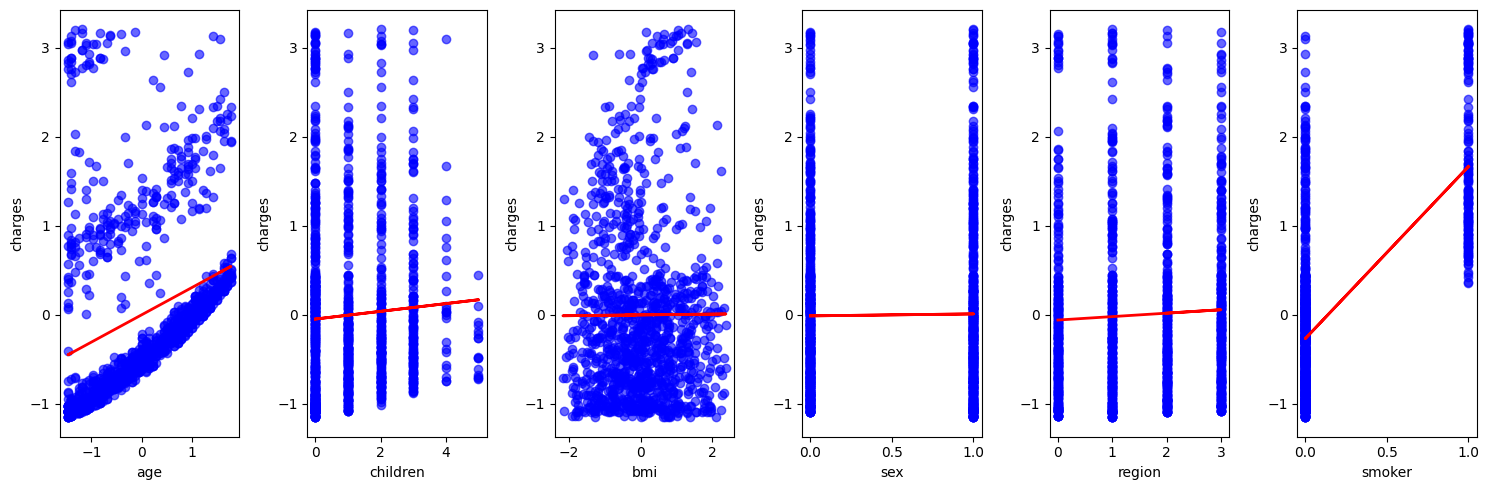

In [81]:
## Plotting the data from scratch

# Create subplots for each predictor
fig, axes = plt.subplots(nrows=1, ncols=len(predictors), figsize=(15, 5))

# Create a DataFrame to store the regression coefficients
coefficients_df = pd.DataFrame(columns=['Predictor', 'Coefficient'])

for i, predictor in enumerate(predictors):
    # Prepare data for the plot
    X = df[[predictor]]
    y = df[response]

    # Create the Linear Regression model
    reg = LinearRegression()
    reg.fit(X, y)

    # Plot the data points
    axes[i].scatter(X, y, color='blue', alpha=0.6)

    # Plot the regression line
    axes[i].plot(X, reg.predict(X), color='red', linewidth=2)
    axes[i].set_xlabel(predictor)
    axes[i].set_ylabel(response)

    # Add the regression coefficient to the DataFrame
    coefficients_df = coefficients_df.append({'Predictor': predictor, 'Coefficient': reg.coef_[0]}, ignore_index=True)
plt.tight_layout()
plt.show()

children Coefficients
0.04331173391606555 -0.046392331417292876


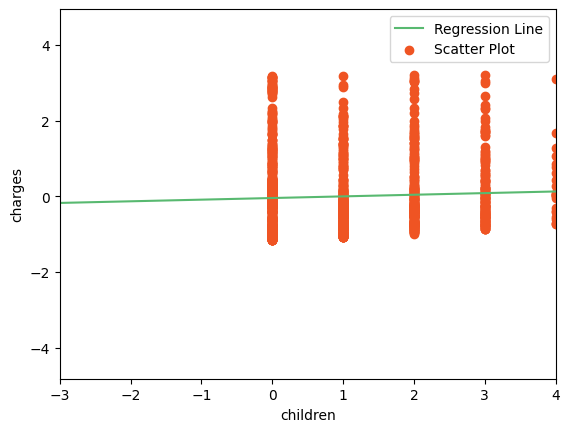

children RMSE
0.9981962475060613
R2 Score
0.0027598482880931696
------------
age Coefficients
0.30521341753662523 1.3380180996312943e-17


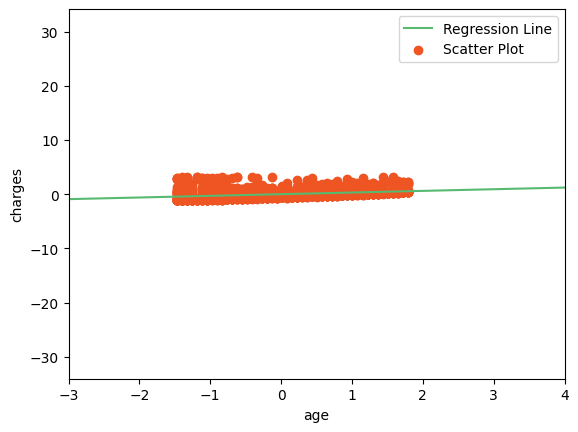

age RMSE
0.9518807215030669
R2 Score
0.0931552302443861
------------
bmi Coefficients
0.00439729743991952 2.2535231086769386e-17


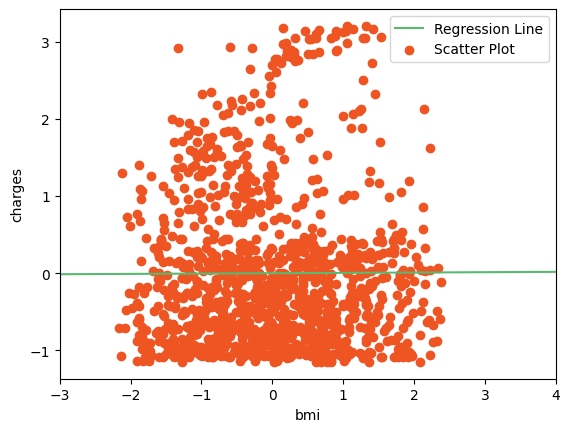

bmi RMSE
0.9995668762504967
R2 Score
1.9336224775456934e-05
------------


In [82]:
#linear regression from scratch with rmse and r2_score
numerical_features_besides_charges = ['children', 'age', 'bmi']
for column in numerical_features_besides_charges:
#rmse = root mean square error
  # Collecting X and Y
  X = df[column].values
  Y = df['charges'].values

  # Calculating coefficient

  # Mean X and Y
  mean_x = np.mean(X)
  mean_y = np.mean(Y)

  # Total number of values
  n = len(X)
  #b1 = Σ((Xi - mean(X))(Yi - mean(Y))) / Σ((Xi - mean(X))^2) and b0 = mean(Y) - b1 * mean(X).
  # Using the formula to calculate b1 and b2
  numer = 0
  denom = 0
  for i in range(n):
      numer += (X[i] - mean_x) * (Y[i] - mean_y)
      denom += (X[i] - mean_x) ** 2
  b1 = numer / denom
  b0 = mean_y - (b1 * mean_x)

  # Printing coefficients
  print(f"{column} Coefficients")
  print(b1, b0)

  # Plotting Values and Regression Line

  max_x = np.max(X) + 100
  min_x = np.min(X) - 100

  # Calculating line values x and y
  x = np.linspace(min_x, max_x, 1000)
  y = b0 + b1 * x

  # Ploting Line
  plt.plot(x, y, color='#58b970', label='Regression Line')
  # Ploting Scatter Points
  plt.scatter(X, Y, c='#ef5423', label='Scatter Plot')

  plt.xlabel(f"{column}")
  plt.ylabel('charges')
  plt.xlim(-3, 4)
  plt.legend()
  plt.show()

  # Calculating Root Mean Squares Error
  rmse = 0
  for i in range(n):
      y_pred = b0 + b1 * X[i]
      rmse += (Y[i] - y_pred) ** 2
  rmse = np.sqrt(rmse/n)

  # Calculating R2 Score
  ss_tot = 0
  ss_res = 0
  for i in range(n):
      y_pred = b0 + b1 * X[i]
      ss_tot += (Y[i] - mean_y) ** 2
      ss_res += (Y[i] - y_pred) ** 2
  r2 = 1 - (ss_res/ss_tot)
  print(f"{column} RMSE")
  print(rmse)
  print("R2 Score")
  print(r2)
  print('------------')

In [83]:
#linear regression using python library with rmse and r2_score

for column in numerical_features_besides_charges:

  # Collecting X and Y
  X = df[column].values
  Y = df['charges'].values

  m = len(X)

  X = X.reshape((m, 1))
  # Model Intialization
  reg = LinearRegression()
  # Data Fitting
  reg = reg.fit(X, Y)
  # Y Prediction
  Y_pred = reg.predict(X)

  # Model Evaluation
  rmse = np.sqrt(mean_squared_error(Y, Y_pred))
  r2 = reg.score(X, Y)

  print(f"{column} RMSE")
  print(rmse)
  print("R2 Score")
  print(r2)
  print('------------')

children RMSE
0.9981962475060613
R2 Score
0.0027598482880936137
------------
age RMSE
0.9518807215030674
R2 Score
0.09315523024438543
------------
bmi RMSE
0.999566876250497
R2 Score
1.933622477534591e-05
------------


#Multivarialbe linear regression on the response variable against all the predictors

In [84]:
x = df.drop(columns=["charges"] , axis = 1)
y = df["charges"]

# Model Intialization
model = LinearRegression()
# Data Fitting
model.fit(x, y)
# Y Prediction
y_pred = model.predict(x)

# Model Evaluation
rmse = np.sqrt(mean_squared_error(y, y_pred))
mse = mean_squared_error(y, y_pred)
r2 = r2_score(y, y_pred)

print("RMSE")
print(rmse)
print("MSE")
print(mse)
print("R2 Score")
print(r2)
print("Intercept:", model.intercept_)
print("Coefficients:", model.coef_)

RMSE
0.6250645069864977
MSE
0.3907056378942735
R2 Score
0.6089632556329349
Intercept: -0.39377095048646094
Coefficients: [ 0.37788738 -0.03080995  0.11831168  0.05378538  2.13357776  0.03924418]
